# Clustering - DBSCAN

In [112]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import itertools
import env
from sqlalchemy import text, create_engine

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler


# Use DBSCAN to detect anomalies in other products from the `customers` dataset. The database name is `grocery_db`.


## Get the Data 

In [86]:
# Customers dataset
from env import host, user, password

def get_connection_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [87]:
url = get_connection_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Step 1. Cluster on features

In [88]:
# Cluster on all or a selected subset of features
frozen_deli_fresh = df[['Frozen','Delicassen','Fresh']]
frozen_deli_fresh.head()

,Frozen,Delicassen,Fresh
customer_id,,,
0,214,1338,12669
1,1762,1776,7057
2,2405,7844,6353
3,6404,1788,13265
4,3915,5185,22615


### Step 2. Array and Float

In [89]:
# checking dtypes
frozen_deli_fresh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Frozen      440 non-null    int64
 1   Delicassen  440 non-null    int64
 2   Fresh       440 non-null    int64
dtypes: int64(3)
memory usage: 13.8 KB


In [90]:
frozen_deli_fresh.iloc[0]

Frozen          214
Delicassen     1338
Fresh         12669
Name: 0, dtype: int64

In [91]:
# changed types to array
frozen_deli_fresh.values.astype("float32",copy=False)[0]

array([  214.,  1338., 12669.], dtype=float32)

In [92]:
#convert to an array and turn into float and save
np_array = frozen_deli_fresh.values.astype("float32",copy=False)

### Step 3. Scale

In [93]:
# MAKE the scaler
minmax = MinMaxScaler()

# FIT/transform the scaler
frozen_deli_fresh_scaled = minmax.fit_transform(np_array)

frozen_deli_fresh_scaled

array([[0.0031063 , 0.02784731, 0.11294005],
       [0.02854842, 0.03698373, 0.06289903],
       [0.03911643, 0.16355862, 0.05662161],
       ...,
       [0.00677142, 0.03888194, 0.12954311],
       [0.01664914, 0.04426366, 0.09172701],
       [0.00065742, 0.00102211, 0.02482434]], dtype=float32)

In [94]:
# using list comprehesion to get new column names
["Scaled_"+column for column in frozen_deli_fresh]

['Scaled_Frozen', 'Scaled_Delicassen', 'Scaled_Fresh']

In [95]:
# Now, let's add the scaled value columns back onto the dataframe
scaled_columns = ["Scaled_"+column for column in frozen_deli_fresh]

In [96]:
# Save a copy of the original dataframe
original_df = df.copy()

In [97]:
# Create a dataframe containing the scaled array of values
scaled_df = pd.DataFrame(frozen_deli_fresh_scaled, columns = scaled_columns)

In [98]:
scaled_df

,Scaled_Frozen,Scaled_Delicassen,Scaled_Fresh
0,0.003106,0.027847,0.112940
1,0.028548,0.036984,0.062899
2,0.039116,0.163559,0.056622
3,0.104842,0.037234,0.118254
4,0.063934,0.108093,0.201626
...,...,...,...
435,0.215469,0.045912,0.264829
436,0.073713,0.048874,0.349761
437,0.006771,0.038882,0.129543
438,0.016649,0.044264,0.091727


In [99]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns={'key_0'})

In [100]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Delicassen,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.027847,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.036984,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.163559,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.037234,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.108093,0.201626


### Step 4. Make the DBSCAN

In [101]:
# Make the object
dbsc = DBSCAN(eps=.1, min_samples=20)

# Fit the object
dbsc.fit(frozen_deli_region_scaled)

DBSCAN(eps=0.1, min_samples=20)

### Step 5. Get Labels

In [102]:
# look at the labels
dbsc.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

### Step 6. Add back to original

In [103]:
# Assign the cluster labels
df['frozen_deli_fresh_labels'] = dbsc.labels_

In [104]:
#see what this dataframe looks like
df.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Delicassen,Scaled_Fresh,frozen_deli_fresh_labels
331,2,2,11223,14881,26839,1234,9606,1102,0.019870,0.022924,0.100046,0
385,1,3,11635,922,1614,2583,192,1068,0.042042,0.022215,0.103720,0
165,2,3,15615,12653,19858,4425,7108,2379,0.072316,0.049562,0.139209,0
174,1,3,286,1208,5241,2515,153,1442,0.040924,0.030017,0.002523,0
161,1,3,12434,540,283,1092,3,2233,0.017537,0.046516,0.110845,0


### Step 7. Explore

In [105]:
#let's see what labels holds
df.frozen_deli_fresh_labels.value_counts()

 0    422
-1     18
Name: frozen_deli_fresh_labels, dtype: int64

In [106]:
# looking at all possible combinations
for combination in itertools.combinations(frozen_deli_fresh.columns, 2):
    print(combination)

('Frozen', 'Delicassen')
('Frozen', 'Fresh')
('Delicassen', 'Fresh')


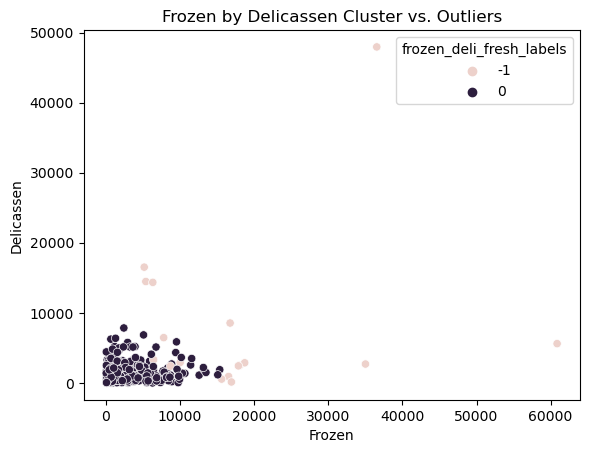

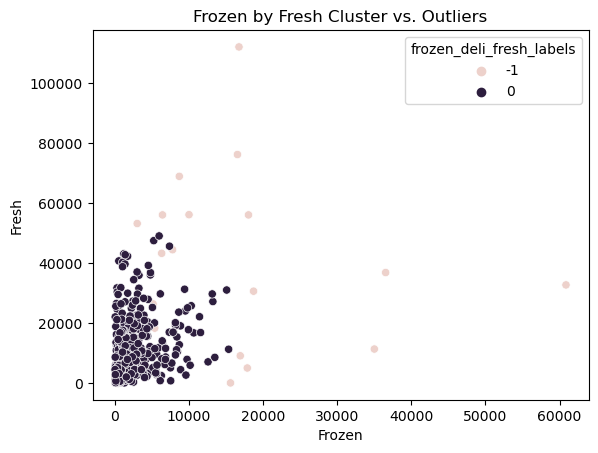

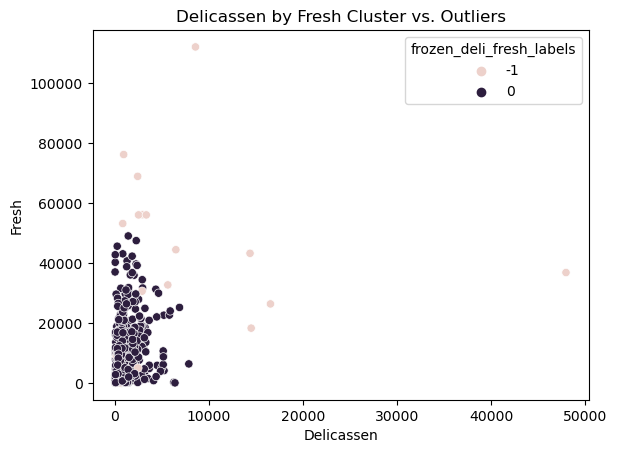

In [107]:
# plot results
for combination in itertools.combinations(frozen_deli_fresh.columns, 2):
    sns.scatterplot(df[combination[0]], df[combination[1]], hue=df.frozen_deli_fresh_labels)
    plt.title(f"{combination[0]} by {combination[1]} Cluster vs. Outliers")
    plt.show()

# 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the `curriculum_logs` database.

In [249]:
# Get the data
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
engine = create_engine(url)    
df = pd.read_sql(text('SELECT * FROM api_access'), engine.connect())
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [250]:
df.timestamp = df.timestamp.astype('datetime64')

In [251]:
df = df.set_index('timestamp')

In [269]:
df = df.sort_index()
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,Scaled_size,Scaled_status_code
0,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.997584,0.0
1,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.006932,0.0
2,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.997584,0.0
3,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.006932,0.0
4,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.992928,0.0
...,...,...,...,...,...,...,...,...,...
24221,97.105.19.58,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0,0.996195,0.0
24222,97.105.19.58,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0,0.992993,0.0
24223,97.105.19.58,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0,0.996195,0.0
24224,97.105.19.58,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0,0.992993,0.0


## 1. Cluster on features

In [270]:
# select features
size_status = df[['size', 'status_code']]
size_status.shape

(24226, 2)

## 2. Array and Float

In [271]:
# changed types to array
size_status.values.astype("float32",copy=False)[0]

array([5.12495e+05, 2.00000e+02], dtype=float32)

In [272]:
#convert to an array and turn into float and save
np_array = size_status.values.astype("float32",copy=False)
np_array

array([[5.12495e+05, 2.00000e+02],
       [5.12495e+05, 2.00000e+02],
       [3.56100e+03, 2.00000e+02],
       ...,
       [5.10136e+05, 2.00000e+02],
       [5.10136e+05, 2.00000e+02],
       [5.10166e+05, 2.00000e+02]], dtype=float32)

## 3. Scale

In [273]:
# MAKE the scaler
minmax = MinMaxScaler()

# FIT/transform the scaler
size_status_scaled = minmax.fit_transform(np_array)

size_status_scaled.shape

(24226, 2)

In [274]:
# using list comprehesion to get new column names
["scaled_"+column for column in size_status]

['scaled_size', 'scaled_status_code']

In [275]:
# Now, let's add the scaled value columns back onto the dataframe
scaled_columns = ["scaled_"+column for column in size_status]

In [276]:
# Save a copy of the original dataframe
original_df = df.copy()

In [277]:
# Create a dataframe containing the scaled array of values
scaled_df = pd.DataFrame(size_status_scaled, columns = scaled_columns)

In [278]:
scaled_df

,scaled_size,scaled_status_code
0,0.997584,0.0
1,0.997584,0.0
2,0.006932,0.0
3,0.006932,0.0
4,0.992928,0.0
...,...,...
24221,0.996195,0.0
24222,0.996195,0.0
24223,0.992993,0.0
24224,0.992993,0.0


In [279]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns={'key_0'})

In [280]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,Scaled_size,Scaled_status_code,scaled_size,scaled_status_code
0,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.997584,0.0,0.997584,0.0
1,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.006932,0.0,0.997584,0.0
2,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.997584,0.0,0.006932,0.0
3,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.006932,0.0,0.006932,0.0
4,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.992928,0.0,0.992928,0.0


### Step 4. Make the DBSCAN

In [281]:
# Make the object
dbsc = DBSCAN(eps=.1, min_samples=10)

# Fit the object
dbsc.fit(size_status_scaled)

DBSCAN(eps=0.1, min_samples=10)

### Step 5. Get Labels

In [282]:
# look at the labels
dbsc.labels_

array([0, 0, 1, ..., 0, 0, 0])

### Step 6. Add back to original

In [283]:
# Assign the cluster labels
df['size_status_labels'] = dbsc.labels_

In [284]:
#see what this dataframe looks like
df.sample(5)

,ip,request_method,request_path,http_version,status_code,size,user_agent,Scaled_size,Scaled_status_code,scaled_size,scaled_status_code,size_status_labels
10286,97.105.19.58,GET,/api/v1/sales?page=154,HTTP/1.1,200,511986,python-requests/2.21.0,0.996594,0.0,0.996594,0.0,0
15094,97.105.19.58,GET,/api/v1/sales?page=161,HTTP/1.1,200,512079,python-requests/2.21.0,0.992804,0.0,0.996775,0.0,0
12084,97.105.19.58,GET,/api/v1/sales?page=64,HTTP/1.1,200,511251,python-requests/2.21.0,0.995163,0.0,0.995163,0.0,0
7723,97.105.19.58,GET,/api/v1/stores?page=3,HTTP/1.1,200,1328,python-requests/2.21.0,0.002585,0.0,0.002585,0.0,1
9806,97.105.19.58,GET,/api/v1/sales?page=126,HTTP/1.1,200,510458,python-requests/2.21.0,0.000000,1.0,0.993619,0.0,0


### Step 7. Explore

In [285]:
#let's see what labels holds
df.size_status_labels.value_counts()

 0    19821
 1     4235
 2      127
 3       35
-1        8
Name: size_status_labels, dtype: int64

In [286]:
# looking at all possible combinations
for combination in itertools.combinations(size_status.columns, 2):
    print(combination)

('size', 'status_code')


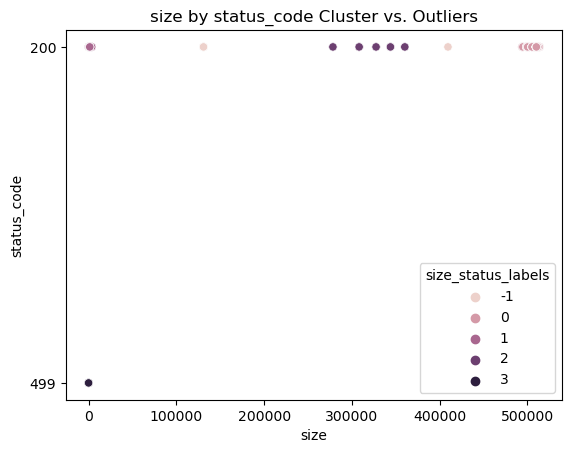

In [287]:
# plot results
for combination in itertools.combinations(size_status.columns, 2):
    sns.scatterplot(df[combination[0]], df[combination[1]], hue=df.size_status_labels)
    plt.title(f"{combination[0]} by {combination[1]} Cluster vs. Outliers")
    plt.show()

# 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the <a href="https://ds.codeup.com/clustering/explore/#exercises">clustering evaluation exercises</a> (single unit properties with a logerror).

In [294]:
def get_connection(db):
    '''This functions grants access to server with eny credentials'''
    return f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{db}'

def check_file_exists(fn, query, url):
    '''check if file exists in my local directory, if not, pull from sql db
    return dataframe'''
    if os.path.isfile(fn):
        print('CSV file found and loaded')
        return pd.read_csv(fn, index_col=0)
    else: 
        print('Creating df and exporting CSV...')
        df = pd.read_sql(query, url)
        df.to_csv(fn)
        return df 
print(f'Load in successful, awaiting commands...')

def get_zillow():
    url = env.get_connection('zillow')
    query = """SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
            taxvaluedollarcnt, fips, transactiondate, parcelid
            FROM properties_2017
            JOIN predictions_2017 using (parcelid)
            WHERE propertylandusetypeid like 261;"""
    filename = 'zillow.csv'
    df = check_file_exists(filename, query, url)

    return df

# -------------------------------------------------------------------------

#  EXPLORE

def wrangle_zillow(df):
    """This function is meant to clean and return the prepared df with identifying
    and removing outliers.
    ---
    Further shrinking the outliers to prevent skewing of the data for the 
    target audience.
    """
    print(f"Prepare Details")
    
    # rename columns
    df = df.rename(columns = {'bedroomcnt':'bed', 'bathroomcnt':'bath', 'calculatedfinishedsquarefeet':\
    'sqft', 'taxvaluedollarcnt': 'assessed_worth', 'fips':'county', 'transactiondate':'date'})
    print(f"--------------------------------------------")
    print(f"Renamed columns for ease of use")

    # drop parcelid and use (used for initial exploration only)
    df = df.drop(columns=['parcelid'])

    # drop all nulls
    df_clean = df.dropna()
    print(f"Nulls removed: Percent Original Data Remaining: {round(df_clean.shape[0]/df.shape[0]*100,0)}")

    # change data types and map FIPS code
    df_clean.county = df_clean.county.map({6037:"LA", 6059:"Orange", 6111:"Ventura"})
    df_clean.bed = df_clean.bed.astype(int)
    print(f"Bed datatype changed from float to integer\nChanged FIPS code to actual county name")
    print(f"--------------------------------------------")

    # outliers ACTUAL
    col_cat = [] #this is for my categorical variables 
    col_num = [] #this is for my numerical variables 
    for col in df_clean.columns: 
        if col in df_clean.select_dtypes(include=['int64', 'float64']): 
            col_num.append(col) 
        else: 
            col_cat.append(col) 

    for col in col_cat: 
        print(f"{col.capitalize().replace('_', ' ')} is a categorical column.") 
    print(f"--------------------------------------------")
    print('Outliers Calculated with IQR Ranges, multiplier 1.5')

    for col in col_num: 
        q1 = df_clean[col].quantile(.25) 
        q3 = df_clean[col].quantile(.75) 
        iqr = q3 - q1 
        upper_bound = q3 + (1.5 * iqr) 
        lower_bound = q1 - (1.5 * iqr) 
        print(f"{col.capitalize().replace('_', ' ')} < = {upper_bound.round(2)} and > {lower_bound.round(2)}") 
        df_clean = df_clean[(df_clean[col] <= upper_bound) & (df_clean[col] >= lower_bound)] 

    print(f"Outliers removed: Percent Original Data Remaining: {round(df_clean.shape[0]/df.shape[0]*100,0)}")

    return df_clean

def outliers_zillow(df,m):
    """This function uses a built-in outlier function to scientifically identify
    all outliers in the zillow dataset and then print them out for each column.
    """
    col_cat = [] #this is for my categorical varibles
    col_num = [] #this is for my numerical varibles

    for col in df.columns:
        if col in df.select_dtypes(include=['int64', 'float64']):
            col_num.append(col)
        else:
            col_cat.append(col)

    for col in col_cat:
        print(f"{col.capitalize().replace('_',' ')} is a categorical column.")
    
    for col in col_num:
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)
        iqr = q3 - q1
        upper_bound = q3 + (m * iqr)
        lower_bound = q1 - (m * iqr)
        # print(f"{col.capitalize().replace('_',' ')}: upper,lower ({upper_bound}, {lower_bound})")
    return upper_bound, lower_bound

Load in successful, awaiting commands...


In [295]:
df1 = get_zillow()
df1

Creating df and exporting CSV...


,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,transactiondate,parcelid
0,4.0,3.5,3100.0,1023282.0,6059.0,2017-01-01,14297519
1,2.0,1.0,1465.0,464000.0,6111.0,2017-01-01,17052889
2,3.0,2.0,1243.0,564778.0,6059.0,2017-01-01,14186244
3,4.0,3.0,2376.0,145143.0,6037.0,2017-01-01,12177905
4,4.0,3.0,2962.0,773303.0,6037.0,2017-01-01,12095076
...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,354621.0,6037.0,2017-09-20,11000655
52438,4.0,2.0,1612.0,67205.0,6111.0,2017-09-21,17239384
52439,3.0,1.0,1032.0,49546.0,6037.0,2017-09-21,12773139
52440,3.0,2.0,1762.0,522000.0,6037.0,2017-09-25,12826780


In [296]:
df = wrangle_zillow(df1)
df

Prepare Details
--------------------------------------------
Renamed columns for ease of use
Nulls removed: Percent Original Data Remaining: 100.0
Bed datatype changed from float to integer
Changed FIPS code to actual county name
--------------------------------------------
County is a categorical column.
Date is a categorical column.
--------------------------------------------
Outliers Calculated with IQR Ranges, multiplier 1.5
Bed < = 5.5 and > 1.5
Bath < = 4.5 and > 0.5
Sqft < = 3640.0 and > -160.0
Assessed worth < = 1135281.5 and > -386956.5
Outliers removed: Percent Original Data Remaining: 88.0


,bed,bath,sqft,assessed_worth,county,date
0,4,3.5,3100.0,1023282.0,Orange,2017-01-01
1,2,1.0,1465.0,464000.0,Ventura,2017-01-01
2,3,2.0,1243.0,564778.0,Orange,2017-01-01
3,4,3.0,2376.0,145143.0,LA,2017-01-01
4,4,3.0,2962.0,773303.0,LA,2017-01-01
...,...,...,...,...,...,...
52437,2,2.0,1286.0,354621.0,LA,2017-09-20
52438,4,2.0,1612.0,67205.0,Ventura,2017-09-21
52439,3,1.0,1032.0,49546.0,LA,2017-09-21
52440,3,2.0,1762.0,522000.0,LA,2017-09-25


## 1. Cluster on features

In [297]:
# select features
bed_sqft = df[['bed', 'sqft']]
bed_sqft.shape

(45902, 2)

## 2. Array and Float

In [298]:
# changed types to array
bed_sqft.values.astype("float32",copy=False)[0]

array([   4., 3100.], dtype=float32)

In [299]:
#convert to an array and turn into float and save
np_array = bed_sqft.values.astype("float32",copy=False)
np_array

array([[4.000e+00, 3.100e+03],
       [2.000e+00, 1.465e+03],
       [3.000e+00, 1.243e+03],
       ...,
       [3.000e+00, 1.032e+03],
       [3.000e+00, 1.762e+03],
       [3.000e+00, 1.050e+03]], dtype=float32)

## 3. Scale

In [300]:
# MAKE the scaler
minmax = MinMaxScaler()

# FIT/transform the scaler
bed_sqft_scaled = minmax.fit_transform(np_array)
bed_sqft_scaled.shape

(45902, 2)

In [301]:
# using list comprehesion to get new column names
["scaled_"+column for column in bed_sqft]

['scaled_bed', 'scaled_sqft']

In [302]:
# Now, let's add the scaled value columns back onto the dataframe
scaled_columns = ["scaled_"+column for column in bed_sqft]

In [303]:
# Save a copy of the original dataframe
original_df = df.copy()

In [304]:
# Create a dataframe containing the scaled array of values
scaled_df = pd.DataFrame(bed_sqft_scaled, columns = scaled_columns)

In [305]:
scaled_df

,scaled_bed,scaled_sqft
0,0.666667,0.845183
1,0.000000,0.376433
2,0.333333,0.312787
3,0.666667,0.637615
4,0.666667,0.805619
...,...,...
45897,0.000000,0.325115
45898,0.666667,0.418578
45899,0.333333,0.252294
45900,0.333333,0.461583


In [306]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns={'key_0'})

In [307]:
df.head()

,bed,bath,sqft,assessed_worth,county,date,scaled_bed,scaled_sqft
0,4,3.5,3100.0,1023282.0,Orange,2017-01-01,0.666667,0.845183
1,2,1.0,1465.0,464000.0,Ventura,2017-01-01,0.000000,0.376433
2,3,2.0,1243.0,564778.0,Orange,2017-01-01,0.333333,0.312787
3,4,3.0,2376.0,145143.0,LA,2017-01-01,0.666667,0.637615
4,4,3.0,2962.0,773303.0,LA,2017-01-01,0.666667,0.805619


### Step 4. Make the DBSCAN

In [309]:
# Make the object
dbsc = DBSCAN(eps=.5, min_samples=10)

# Fit the object
dbsc.fit(bed_sqft_scaled)

DBSCAN(min_samples=10)

### Step 5. Get Labels

In [310]:
# look at the labels
dbsc.labels_

array([0, 0, 0, ..., 0, 0, 0])

### Step 6. Add back to original

In [311]:
# Assign the cluster labels
df['bed_sqft_labels'] = dbsc.labels_

In [312]:
#see what this dataframe looks like
df.sample(5)

,bed,bath,sqft,assessed_worth,county,date,scaled_bed,scaled_sqft,bed_sqft_labels
17123,5,4.0,3464.0,803000.0,LA,2017-04-24,1.000000,0.949541,0
16247,4,2.0,1594.0,381635.0,LA,2017-04-19,0.666667,0.413417,0
9784,4,3.0,2900.0,464894.0,LA,2017-03-14,0.666667,0.787844,0
15054,4,3.0,2632.0,1066576.0,Orange,2017-04-12,0.666667,0.711009,0
3009,3,2.0,1605.0,453000.0,LA,2017-01-24,0.333333,0.416571,0


### Step 7. Explore

In [313]:
#let's see what labels holds
df.bed_sqft_labels.value_counts()

0    45902
Name: bed_sqft_labels, dtype: int64

In [314]:
# looking at all possible combinations
for combination in itertools.combinations(bed_sqft.columns, 2):
    print(combination)

('bed', 'sqft')


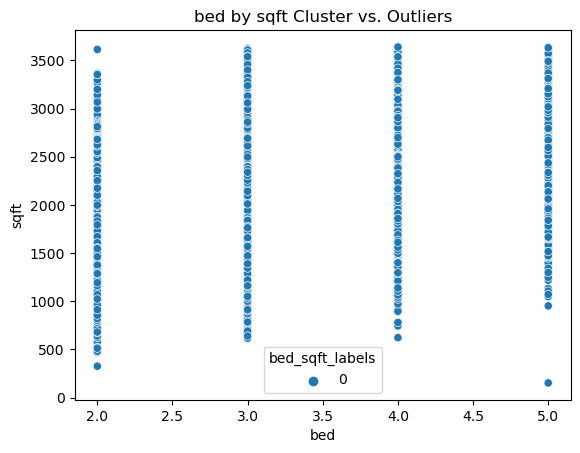

In [318]:
# plot results
for combination in itertools.combinations(bed_sqft.columns, 2):
    sns.scatterplot(df[combination[0]], df[combination[1]], hue=df.bed_sqft_labels)
    plt.title(f"{combination[0]} by {combination[1]} Cluster vs. Outliers")
    plt.show()